In [0]:
!pip install ibm-cos-sdk

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import pandas as pd
tf.enable_eager_execution()
tf.__version__
import os, sys, glob
import ibm_boto3
from ibm_botocore.client import Config

Add the code below from Ruitka to download the augmented images for training

In [0]:
# BUCKET='w251-final-project'
# auth_endpoint = 'https://iam.bluemix.net/oidc/token'
# service_endpoint = 'https://s3.us-south.cloud-object-storage.appdomain.cloud'

# creds = {
#   "apikey": "f-qBpDnSKCQy-09Qp0ITDMqtuAKL3dw_ceFqbl2plO9z",
#   "cos_hmac_keys": {
#     "access_key_id": "81125ccd0720474695df163a3d531386",
#     "secret_access_key": "022d50955047be30956d7c7c0600d1e911baf16b877ce7bf"
#   },
#   "endpoints": "https://control.cloud-object-storage.cloud.ibm.com/v2/endpoints",
#   "iam_apikey_description": "Auto-generated for key 81125ccd-0720-4746-95df-163a3d531386",
#   "iam_apikey_name": "Service credentials-1",
#   "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Reader",
#   "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/37d593cd072c45d790ab0474d61bb350::serviceid:ServiceId-f507b0a6-adda-4fd4-ae74-8072bcac69cc",
#   "resource_instance_id": "crn:v1:bluemix:public:cloud-object-storage:global:a/37d593cd072c45d790ab0474d61bb350:f7e02bf8-aadf-4b08-bcdd-62e88994d0a8::"
# }

# resource = ibm_boto3.resource('s3',
#                 ibm_api_key_id=creds['apikey'],
#                 ibm_service_instance_id=creds['resource_instance_id'],
#                 ibm_auth_endpoint=auth_endpoint,
#                 config=Config(signature_version='oauth'),
#                 endpoint_url=service_endpoint)

# if __name__ == "__main__":
#     os.mkdir('/content/drive/My Drive/Colab Notebooks/w251_finalProject/split_data')
#     os.mkdir('/content/drive/My Drive/Colab Notebooks/w251_finalProject/split_data/train')
#     os.mkdir('/content/drive/My Drive/Colab Notebooks/w251_finalProject/split_data/test')
#     os.mkdir('/content/drive/My Drive/Colab Notebooks/w251_finalProject/split_data/validation')

#     # get list of objects from the bucket
#     client = resource.meta.client
#     page = client.get_paginator('list_objects')
#     for page in page.paginate(Bucket=BUCKET):
#         keys = [{'Key': obj['Key']} for obj in page.get('Contents', [])]
#         if keys:
#             for k in keys:
#                 key = k['Key']
#                 path = '/content/drive/My Drive/Colab Notebooks/w251_finalProject/split_data/' + '/'.join(key.split('/')[:-1])
#                 if not os.path.exists(path):
#                     os.mkdir(path)
#                 # download key to path
#                 filename = '/content/drive/My Drive/Colab Notebooks/w251_finalProject/split_data/' + key
#                 print(filename)
#                 client.download_file(Bucket=BUCKET, Key=key, Filename=filename)

Import the images 

In [3]:
import random
import pathlib

data_root = pathlib.Path('/content/drive/My Drive/Colab Notebooks/w251_finalProject/split_data/train/')

all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
print(image_count)

data_root_val = pathlib.Path('/content/drive/My Drive/Colab Notebooks/w251_finalProject/split_data/validation/')
data_root_test = pathlib.Path('/content/drive/My Drive/Colab Notebooks/w251_finalProject/split_data/test/')

val_image_paths = list(data_root_val.glob('*/*'))
val_image_paths = [str(path) for path in val_image_paths]
random.shuffle(val_image_paths)

val_image_count = len(val_image_paths)
print(val_image_count)

2865
718


In [4]:
all_image_paths[:10]

['/content/drive/My Drive/Colab Notebooks/w251_finalProject/split_data/train/PERSON/image_0086_translated_2.png',
 '/content/drive/My Drive/Colab Notebooks/w251_finalProject/split_data/train/BEYONCE/355_translated_2.png',
 '/content/drive/My Drive/Colab Notebooks/w251_finalProject/split_data/train/PERSON/image_0335_translated_0.png',
 '/content/drive/My Drive/Colab Notebooks/w251_finalProject/split_data/train/PERSON/image_0094_translated_3.png',
 '/content/drive/My Drive/Colab Notebooks/w251_finalProject/split_data/train/PERSON/image_0394_translated_2.png',
 '/content/drive/My Drive/Colab Notebooks/w251_finalProject/split_data/train/PERSON/image_0050_translated_1.png',
 '/content/drive/My Drive/Colab Notebooks/w251_finalProject/split_data/train/PERSON/image_0019_translated_3.png',
 '/content/drive/My Drive/Colab Notebooks/w251_finalProject/split_data/train/BEYONCE/108.png',
 '/content/drive/My Drive/Colab Notebooks/w251_finalProject/split_data/train/PERSON/image_0121.png',
 '/content/d

In [0]:
# based on the path/folder of each image, specify the label for the image. 
# e.g. images from BEYONCE folder should have the label name BEYONCE
all_image_labels = []
for i in all_image_paths:
  path_temp_list = list(i.split("/"))
  all_image_labels.append(path_temp_list[-2])

val_image_labels = []
for i in val_image_paths:
  path_temp_list = list(i.split("/"))
  val_image_labels.append(path_temp_list[-2])

In [6]:
all_image_labels[:10]

['PERSON',
 'BEYONCE',
 'PERSON',
 'PERSON',
 'PERSON',
 'PERSON',
 'PERSON',
 'BEYONCE',
 'PERSON',
 'PERSON']

In [7]:
cate_list = pd.read_csv('/content/drive/My Drive/Colab Notebooks/w251_finalProject/split_data/category.txt', header=None)
label_names = cate_list.iloc[:,0].tolist()
label_names

['ALEC BALDWIN', 'ANNE HATHAWAY', 'BEYONCE', 'BILL MURRAY', 'PERSON']

In [8]:
# convert the class labels to numbers representing each class
label_to_index = dict((name, index) for index,name in enumerate(label_names))
label_to_index

{'ALEC BALDWIN': 0,
 'ANNE HATHAWAY': 1,
 'BEYONCE': 2,
 'BILL MURRAY': 3,
 'PERSON': 4}

In [9]:
# convert all image labels to the numbers as specified in the last step
all_image_labels = [label_to_index[i]
                    for i in all_image_labels]

print("First 10 labels indices: ", all_image_labels[:10])

val_image_labels = [label_to_index[i]
                    for i in val_image_labels]

print("First 10 labels indices: ", val_image_labels[:10])

First 10 labels indices:  [4, 2, 4, 4, 4, 4, 4, 2, 4, 4]
First 10 labels indices:  [4, 3, 2, 4, 4, 4, 4, 1, 4, 4]


In [0]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
path_ds_val = tf.data.Dataset.from_tensor_slices(val_image_paths)


In [0]:
import numpy as np
def preprocess_image(image):
  image = tf.image.decode_png(image, channels=3)
#   image = np.array(image, dtype=float)
  image = tf.image.resize(image, [192, 192])
  image /= 255.0  # normalize to [0,1] range

  return image

def load_and_preprocess_image(path):
  image = tf.read_file(path)
  return preprocess_image(image)

AUTOTUNE = tf.data.experimental.AUTOTUNE


In [0]:
# pre-processing the images
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
image_ds_val = path_ds_val.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)


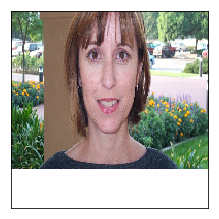

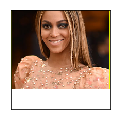

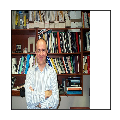

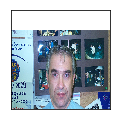

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
for n,image in enumerate(image_ds.take(4)):
  plt.subplot(2,2,n+1)
  plt.imshow(image)
#   Image.fromarray(np.asarray(image)).show()
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
#   plt.xlabel(caption_image(all_image_paths[n]))
  plt.show()

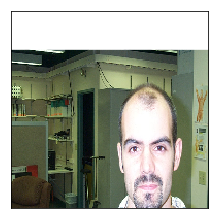

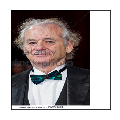

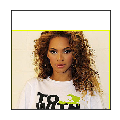

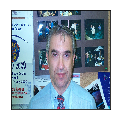

In [14]:
plt.figure(figsize=(8,8))
for n,image in enumerate(image_ds_val.take(4)):
  plt.subplot(2,2,n+1)
  plt.imshow(image)
#   Image.fromarray(np.asarray(image)).show()
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
#   plt.xlabel(caption_image(all_image_paths[n]))
  plt.show()

In [0]:
# labels
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
label_ds_val = tf.data.Dataset.from_tensor_slices(tf.cast(val_image_labels, tf.int64))
image_label_ds_val = tf.data.Dataset.zip((image_ds_val, label_ds_val))


In [16]:
print(image_label_ds)


<DatasetV1Adapter shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int64)>


In [17]:
# create pairs of images + labels into a dataset
ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))

# The tuples are unpacked into the positional arguments of the mapped function
def load_and_preprocess_from_path_label(path, label):
  return load_and_preprocess_image(path), label

image_label_ds = ds.map(load_and_preprocess_from_path_label)
print(image_label_ds)

ds_val = tf.data.Dataset.from_tensor_slices((val_image_paths, val_image_labels))

def load_and_preprocess_from_path_label(path, label):
  return load_and_preprocess_image(path), label

image_label_ds_val = ds_val.map(load_and_preprocess_from_path_label)
print(image_label_ds_val)

<DatasetV1Adapter shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int32)>
<DatasetV1Adapter shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int32)>


Prepare the dataset and model for training

In [18]:
BATCH_SIZE = 32

# Setting a shuffle buffer size as large as the dataset ensures that the data is
# completely shuffled.
ds = image_label_ds.shuffle(buffer_size=image_count)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)
# `prefetch` lets the dataset fetch batches, in the background while the model is training.
ds = ds.prefetch(buffer_size=AUTOTUNE)
print(ds)


ds_val = image_label_ds_val.shuffle(buffer_size=val_image_count)
ds_val = ds_val.repeat()
ds_val = ds_val.batch(BATCH_SIZE)
# `prefetch` lets the dataset fetch batches, in the background while the model is training.
ds_val = ds_val.prefetch(buffer_size=AUTOTUNE)
print(ds_val)

<DatasetV1Adapter shapes: ((?, 192, 192, 3), (?,)), types: (tf.float32, tf.int32)>
<DatasetV1Adapter shapes: ((?, 192, 192, 3), (?,)), types: (tf.float32, tf.int32)>


In [19]:
# Just for testing purpose, I am skipping the first 200 samples inside the 
# training dataset to create a validation dataset to see how it works
ds = ds.skip(200)
ds_val = ds.take(200)

ds = image_label_ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE)
ds = ds.prefetch(buffer_size=AUTOTUNE)
print(ds)


# ds_val = image_label_ds_val.apply(
#   tf.data.experimental.shuffle_and_repeat(buffer_size=val_image_count))
# ds_val = ds_val.batch(BATCH_SIZE)
# ds_val = ds_val.prefetch(buffer_size=AUTOTUNE)
# print(ds_val)

W0731 03:47:08.184920 140486729783168 deprecation.py:323] From <ipython-input-19-14501076128a>:5: shuffle_and_repeat (from tensorflow.python.data.experimental.ops.shuffle_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.


<DatasetV1Adapter shapes: ((?, 192, 192, 3), (?,)), types: (tf.float32, tf.int32)>


In [20]:
for image_batch, label_batch in ds.take(1):
  pass
image_batch.shape

TensorShape([Dimension(32), Dimension(192), Dimension(192), Dimension(3)])

In [0]:
# Start building the model

In [0]:
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(192, 192, 3), include_top=False, weights='imagenet')
mobile_net.trainable=False

In [0]:
def change_range(image,label):
  return 2*image-1, label

keras_ds = ds.map(change_range)
keras_ds_val = ds_val.map(change_range)

In [0]:
# The dataset may take a few seconds to start, as it fills its shuffle buffer.
image_batch, label_batch = next(iter(keras_ds))
# The dataset may take a few seconds to start, as it fills its shuffle buffer.
image_batch_val, label_batch_val = next(iter(keras_ds_val))

In [24]:
feature_map_batch = mobile_net(image_batch)
print(feature_map_batch.shape)
feature_map_batch_val = mobile_net(image_batch_val)
print(feature_map_batch_val.shape)

(32, 6, 6, 1280)
(32, 6, 6, 1280)


In [25]:
mobile_net.summary()

Model: "mobilenetv2_1.00_192"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 193, 193, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 96, 96, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 96, 96, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [0]:
model = tf.keras.Sequential([
  mobile_net,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(5)])

In [27]:
logit_batch = model(image_batch).numpy()

print("min logit:", logit_batch.min())
print("max logit:", logit_batch.max())
print()

print("Shape:", logit_batch.shape)

min logit: -2.590951
max logit: 1.9560689

Shape: (32, 5)


In [0]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=["accuracy"])

In [29]:
len(model.trainable_variables)


2

In [30]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [31]:
steps_per_epoch=tf.ceil(len(all_image_paths)/BATCH_SIZE).numpy()
steps_per_epoch

90.0

In [37]:
history_base = model.fit(ds, epochs=10, steps_per_epoch=90)


Epoch 1/10
90/90 [==============================] - 277s 3s/step - loss: 1.6044 - acc: 0.3691
Epoch 2/10
90/90 [==============================] - 231s 3s/step - loss: 1.5888 - acc: 0.5146
Epoch 3/10
90/90 [==============================] - 229s 3s/step - loss: 1.6078 - acc: 0.4372
Epoch 4/10
90/90 [==============================] - 227s 3s/step - loss: 1.6008 - acc: 0.4875
Epoch 5/10
90/90 [==============================] - 227s 3s/step - loss: 1.5729 - acc: 0.5958
Epoch 6/10
90/90 [==============================] - 228s 3s/step - loss: 1.6033 - acc: 0.5222
Epoch 7/10
90/90 [==============================] - 228s 3s/step - loss: 1.5912 - acc: 0.5944
Epoch 8/10
90/90 [==============================] - 230s 3s/step - loss: 1.3336 - acc: 0.7816
Epoch 9/10
90/90 [==============================] - 227s 3s/step - loss: 0.9351 - acc: 0.8056
Epoch 10/10
90/90 [==============================] - 227s 3s/step - loss: 0.9446 - acc: 0.8045


**After retraining the model with the new images and labels, several layers are unfrozen to fine-tune the model and do the retraining**

In [38]:
# Fine-tuning the model
mobile_net.trainable=True
print("Number of layers in the base model: ", len(mobile_net.layers))
fine_tune_at = 25
for layer in mobile_net.layers[:fine_tune_at]:
  layer.trainable =  False
  
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=["accuracy"])
model.summary()

Number of layers in the base model:  155
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 2,217,989
Non-trainable params: 46,400
_________________________________________________________________


In [0]:
history_fine_tune = model.fit(ds, epochs=20, steps_per_epoch=90)


Epoch 1/20
90/90 [==============================] - 547s 6s/step - loss: 1.0855 - acc: 0.4938
Epoch 2/20
90/90 [==============================] - 469s 5s/step - loss: 1.0707 - acc: 0.4688
Epoch 3/20
90/90 [==============================] - 466s 5s/step - loss: 1.0637 - acc: 0.5479
Epoch 4/20
90/90 [==============================] - 466s 5s/step - loss: 2.0632 - acc: 0.5087
Epoch 5/20
90/90 [==============================] - 465s 5s/step - loss: 1.3184 - acc: 0.4656
Epoch 6/20
90/90 [==============================] - 465s 5s/step - loss: 1.2185 - acc: 0.5139
Epoch 7/20
90/90 [==============================] - 466s 5s/step - loss: 1.4408 - acc: 0.2844
Epoch 8/20
49/90 [===============>..............] - ETA: 3:31 - loss: 1.5160 - acc: 0.2022